<a href="https://colab.research.google.com/github/Shuhui11/Hello-World/blob/master/Mammals_Detection_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 369.2MB 54kB/s 
     |████████████████████████████████| 460kB 45.4MB/s 
     |████████████████████████████████| 61kB 25.2MB/s 
     |████████████████████████████████| 3.9MB 43.0MB/s 


# Mammals Project

We want to train a model that can tell the difference between 3 types of mammals.

To do this we are going to use a CNN model called VGG16 to do transfer Learning.

Along the way will also use the new tf.data along with Pandas to handle the input pipelines for training and testing.

#Testing for GPU

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Importing data from Google Drive


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -qq "/content/gdrive/My Drive/Classification/Classes.zip"

In [5]:
!ls /content/Labels/

'Argusianus argus'   Human   Macaca   Muntiacus  'Sus barbatus'


#Setting up Tensorflow

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, json
from glob import glob
import numpy as np

import tensorflow as tf

from tensorflow.keras import optimizers

from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard

In [7]:
print(tf.__version__)
print(tf.keras.__version__)

2.0.0-dev20190715
2.2.4-tf


# Converting raw files in folders into something we can feed into tf.data

We use os.walk to get lists of the files in the directories and then convert them into a dataframe and add in class numbers.

We also then split them up so we have 10% for a testing set and the rest for training.

Finally we randomly shuffle them up.



In [8]:
import glob
import pandas as pd

path = "/content/Labels/"

data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
df.dtypes

                                            filename    class_name  class
0     /content/Labels/Macaca/2017 06 29 16 26 54.jpg        Macaca      2
1  /content/Labels/Sus barbatus/2017 06 11 18 47 ...  Sus barbatus      4
2     /content/Labels/Macaca/2017 07 06 13 13 23.jpg        Macaca      2
3      /content/Labels/Human/2017 07 04 09 01 21.jpg         Human      1
4  /content/Labels/Muntiacus/2017 06 22 17 57 02.jpg     Muntiacus      3


filename        object
class_name    category
class             int8
dtype: object

In [9]:
len(df)

2515

In [0]:
# Split into train and validation sets
train_set_percentage = .9

df = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

# Shuffle
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [11]:
# Training dataset
print(df.shape)
print(df_val.shape)

# Classes
df['class'].unique()

(2263, 3)
(227, 3)


array([2, 4, 3, 1, 0])

Sus barbatus        547
Macaca              526
Human               518
Muntiacus           508
Argusianus argus    164
Name: class_name, dtype: int64


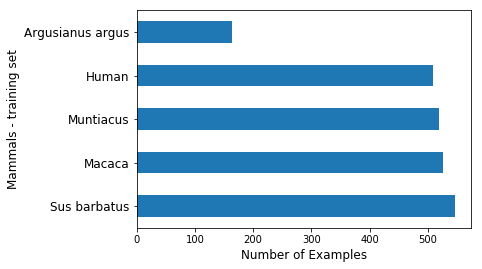

In [12]:
print(df['class_name'].value_counts())


ax = df['class_name'].value_counts().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("Mammals - training set", fontsize=12)
ax.set_yticklabels(['Sus barbatus','Macaca','Muntiacus','Human','Argusianus argus'], rotation=0, fontsize=12)
plt.show()

# Making the pipeline for loading and resizing images

In [13]:
img_rows, img_cols = 224,224
num_classes = 5
batch_size = 33
epochs = 15
learning_rate = 0.001

train_steps = int(len(df)/batch_size)
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

train steps: 68
val steps: 6


#Assembling the data pipeline using tf.data

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32) ))
train_dataset= train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(32, drop_remainder = True)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(100).shuffle(1000)
valid_dataset = valid_dataset.batch(32)

In [16]:
train_dataset

<BatchDataset shapes: ((32, 224, 224, 3), (32, 5)), types: (tf.float32, tf.float32)>

#Creating the base pre-trained model VGG16

In [17]:
# Download VGG network weights
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling=None)

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
# Add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# and a logits layer -- let's say we have 5 classes
predictions = Dense(5, activation='softmax')(x)

In [0]:
# model for training
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
# Train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

In [0]:
# for layer in model.layers:
#     print(layer.name,' Trainable =',layer.trainable)

In [0]:
# model.summary()

In [0]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=0,mode='auto')

opt = tf.keras.optimizers.Adam(lr=learning_rate)

# Compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#Train model using VGG16 as base with validation

In [24]:
### Train the model with validation 
history = model.fit( train_dataset, 
                   steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[early_stopping])

Epoch 1/15


W0715 13:24:14.464294 140320312301440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0715 13:24:14.626040 140320312301440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


68/68 [==============================] - 182s 3s/step - loss: 1.6738 - accuracy: 0.6664 - val_loss: 0.3236 - val_accuracy: 0.8802
Epoch 2/15
68/68 [==============================] - 133s 2s/step - loss: 0.3685 - accuracy: 0.8745 - val_loss: 0.2224 - val_accuracy: 0.9323
Epoch 3/15
68/68 [==============================] - 133s 2s/step - loss: 0.2561 - accuracy: 0.9085 - val_loss: 0.1140 - val_accuracy: 0.9688
Epoch 4/15
68/68 [==============================] - 133s 2s/step - loss: 0.1679 - accuracy: 0.9412 - val_loss: 0.1090 - val_accuracy: 0.9583
Epoch 5/15
68/68 [==============================] - 133s 2s/step - loss: 0.1451 - accuracy: 0.9522 - val_loss: 0.1125 - val_accuracy: 0.9635
Epoch 6/15
68/68 [==============================] - 133s 2s/step - loss: 0.1268 - accuracy: 0.9586 - val_loss: 0.0935 - val_accuracy: 0.9740
Epoch 7/15
68/68 [==============================] - 133s 2s/step - loss: 0.1139 - accuracy: 0.9628 - val_loss: 0.0626 - val_accuracy: 0.9844
Epoch 8/15
68/68 [======

#Creating the base pre-trained model Inceptionv3

In [25]:
base_model_inception = inception_v3.InceptionV3(weights='imagenet', include_top=False)

for layer in base_model_inception.layers:
    if 'batch' in layer.name:
      layer.trainable = True
    else:
      layer.trainable = False 

87916544/87910968 [==============================] - 4s 0us/step


In [0]:
# Add a global spatial average pooling layer
x1 = base_model_inception.output

x1 = GlobalAveragePooling2D()(x1)

# Add a fully-connected layer
x1 = Dense(512, activation='relu')(x1)

x1 = Dropout(0.5)(x1)

# and a logits layer
predictions1 = Dense(5, activation='softmax')(x1)

In [0]:
new_model = Model(inputs=base_model_inception.input, outputs=predictions1)

In [0]:
new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

#Train model using inceptionv3 as base with validation

In [29]:
### Train the model with validation 
history1 = new_model.fit( train_dataset, 
                   steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks = [early_stopping])

Epoch 1/15
68/68 [==============================] - 268s 4s/step - loss: 1.6019 - accuracy: 0.5119 - val_loss: 0.8599 - val_accuracy: 0.6719
Epoch 2/15
68/68 [==============================] - 145s 2s/step - loss: 0.7773 - accuracy: 0.7192 - val_loss: 0.5173 - val_accuracy: 0.8125
Epoch 3/15
68/68 [==============================] - 145s 2s/step - loss: 0.5859 - accuracy: 0.7914 - val_loss: 0.3741 - val_accuracy: 0.8646
Epoch 4/15
68/68 [==============================] - 145s 2s/step - loss: 0.5032 - accuracy: 0.8217 - val_loss: 0.2610 - val_accuracy: 0.9062
Epoch 5/15
68/68 [==============================] - 145s 2s/step - loss: 0.4454 - accuracy: 0.8355 - val_loss: 0.1579 - val_accuracy: 0.9531
Epoch 6/15
68/68 [==============================] - 145s 2s/step - loss: 0.3263 - accuracy: 0.8874 - val_loss: 0.2741 - val_accuracy: 0.8802
Epoch 7/15
68/68 [==============================] - 144s 2s/step - loss: 0.2923 - accuracy: 0.9021 - val_loss: 0.3130 - val_accuracy: 0.8385
Epoch 8/15
68

#Make some predictions

In [0]:
image_path = '/content/gdrive/My Drive/Classification/'

In [0]:
from IPython.display import Image
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

Predicted: [[1.4089455e-06 9.9952197e-01 2.1090240e-05 4.5507416e-04 4.5530331e-07]]
Species based on VGG16: Human
Predicted: [[2.1661426e-06 3.8646128e-02 5.5236300e-03 9.5582056e-01 7.4892769e-06]]
Species based on inceptionv3: Muntiacus


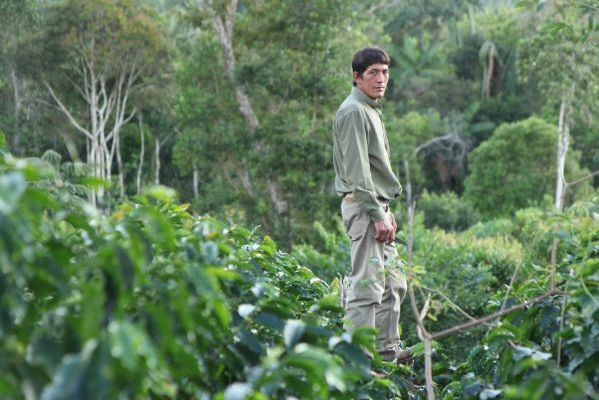

In [53]:
image_check = 'subject_001.jpg'

img_path = os.path.join(image_path, image_check)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on VGG16: ' + species)

img_path = os.path.join(image_path, image_check)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = new_model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on inceptionv3: ' + species)

Image(image_path+image_check)

Predicted: [[1.9240347e-06 4.5173802e-08 2.4386304e-13 9.9999797e-01 5.9853698e-11]]
Species based on VGG16: Muntiacus
Predicted: [[8.3851482e-06 9.9609792e-01 3.7018702e-04 3.4861257e-03 3.7249225e-05]]
Species based on inceptionv3: Human


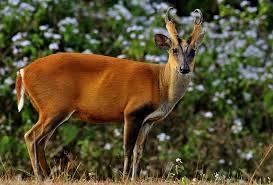

In [54]:
image_check = 'subject_003.jpeg'

img_path = os.path.join(image_path, image_check)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on VGG16: ' + species)

preds = new_model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on inceptionv3: ' + species)

Image(image_path+image_check)

Predicted: [[1.0000000e+00 1.5856311e-09 8.8467091e-16 1.6876983e-10 5.4716476e-10]]
Species based on VGG16: Argusianus argus
Predicted: [[0.00556581 0.9251187  0.01379076 0.04341544 0.01210927]]
Species based on inceptionv3: Human


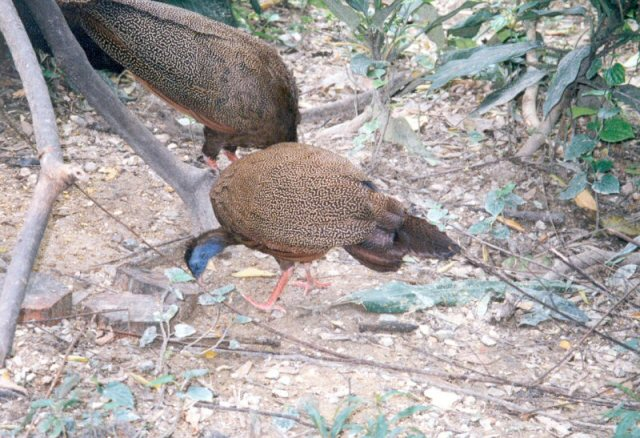

In [55]:
image_check = 'subject_004.jpg'

img_path = os.path.join(image_path, image_check)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on VGG16: ' + species)

preds = new_model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on inceptionv3: ' + species)

Image(image_path+image_check)

Predicted: [[2.4012322e-04 1.9791869e-03 9.9760997e-01 6.0703478e-08 1.7049725e-04]]
Species based on VGG16: Macaca
Predicted: [[1.1417125e-04 3.9943719e-01 1.1567114e-01 4.8476297e-01 1.4516075e-05]]
Species based on inceptionv3: Muntiacus


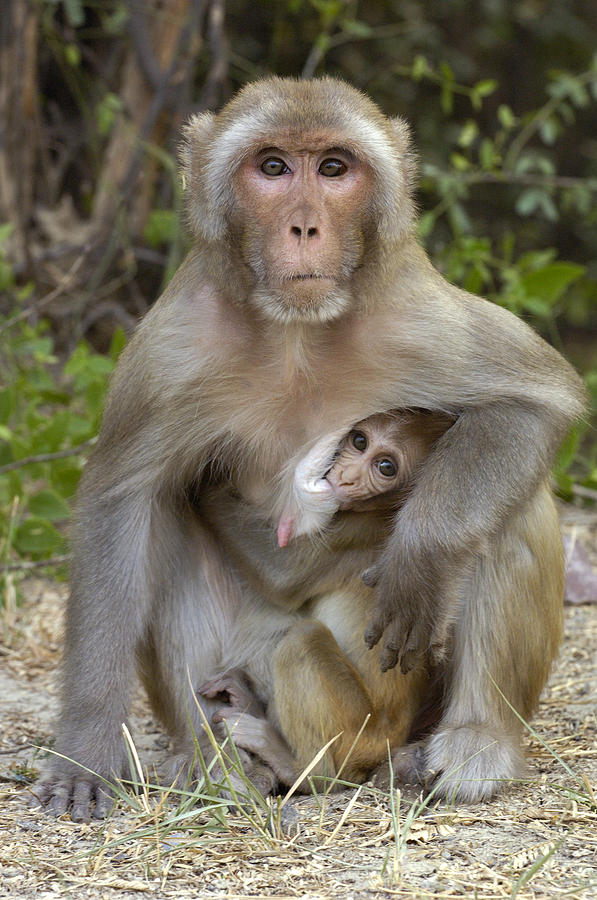

In [56]:
image_check = 'subject_005.jpg'

img_path = os.path.join(image_path, image_check)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on VGG16: ' + species)

preds = new_model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on inceptionv3: ' + species)

Image(image_path+image_check)

Predicted: [[5.3380555e-12 9.9999988e-01 3.3703479e-10 1.0034277e-07 6.9063522e-15]]
Species based on VGG16: Human
Predicted: [[5.5949702e-03 7.5665051e-01 1.4873502e-01 8.8514142e-02 5.0538633e-04]]
Species based on inceptionv3: Human


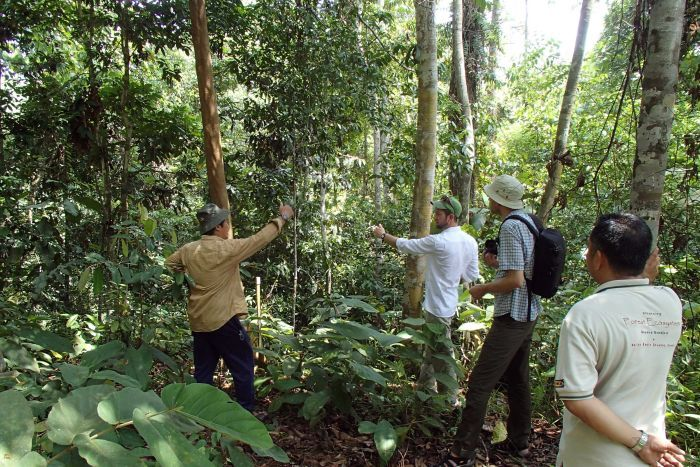

In [57]:
image_check = 'subject_006.jpg'

img_path = os.path.join(image_path, image_check)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on VGG16: ' + species)

preds = new_model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on inceptionv3: ' + species)

Image(image_path+image_check)

Predicted: [[9.9999714e-01 2.8432462e-06 9.8645166e-17 2.9512485e-08 5.7354235e-18]]
Species based on VGG16: Argusianus argus
Predicted: [[2.7031603e-04 9.7041309e-01 1.1631081e-04 2.9186435e-02 1.3721234e-05]]
Species based on inceptionv3: Human


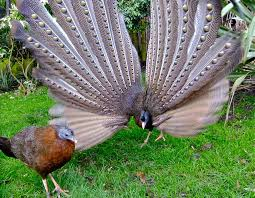

In [58]:
image_check = 'subject_007.jpeg'

img_path = os.path.join(image_path, image_check)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on VGG16: ' + species)

preds = new_model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on inceptionv3: ' + species)

Image(image_path+image_check)

Predicted: [[1.4979248e-08 2.2327060e-12 1.9121052e-14 2.2655122e-06 9.9999774e-01]]
Species based on VGG16: Sus barbatus
Predicted: [[5.4244057e-04 9.4906950e-01 5.0505288e-03 4.1638684e-02 3.6987953e-03]]
Species based on inceptionv3: Human


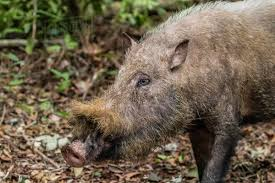

In [59]:
image_check = 'subject_008.jpeg'

img_path = os.path.join(image_path, image_check)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on VGG16: ' + species)

preds = new_model.predict(x)
print('Predicted:', preds)

result = max(preds[0])

if result == preds[0][0]:
  species = 'Argusianus argus'
elif result == preds[0][2]:
  species = 'Macaca'
elif result == preds[0][3]:
  species = 'Muntiacus'
elif result == preds[0][4]:
  species = 'Sus barbatus'
else:
  species = 'Human'
  
print('Species based on inceptionv3: ' + species)

Image(image_path+image_check)

#Conclusion
By comparing the models, where the only the base model differs, it seems that the base model VGG16 is more appropriate when it comes to classifying mammals images from camera traps as it has a higher accuracy. On top of that, the time taken to train the model is also way faster.